# Spectral Analysis with Osciloscope FFT tool

&copy; 2025 L. Horacio Arnaldi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

---

In this notebook, we will investigate the noise generation and analysis using Python. 
We will begin by investigating the creation of different noise types. Then, we will some functions for generating the spectra of these noise.

## Table of Contents
* [1. Introduction](#introduction)
* [2. FFT fundamentals](#fft_fundamentals)
* [3. FFT frequency span and resolution bandwidth](#fft_span_res)
* [4. FFT vertical output formats](#fft_v_formats)
* [5. Weighting functions](#fft_windowing)
* [6. Averaging](#averaging)
* [7. FFT scaling for noise](#fft_scaling_noise)
* [8. Application example](#app_example)
* [9. Conclusion](#conclusion)
* [Appendix A](#appendixa)
* [Appendix B](#appendixb)
* [10. Application exmaple: Simple example of signal creation and FFT analysis](#simple_signal)
* [11. Application example: Different time record analysis](#diff_time_record)

    
## References
* [1] - [Agilent, “Spectral Analysis Using a Deep-Memory
Oscilloscope Fast Fourier Transform (FFT)”, Application Note 1383-1, 2001.](https://hpwiki.mcguirescientificservices.com/_media/application_notes:an-1383-1.pdf)
* [2] - [Arthur Pini, "FFTs and oscilloscopes: A practical guide", EDN, 2016](https://www.edn.com/ffts-and-oscilloscopes-a-practical-guide/?_gl=1*tsz9ct*_ga*ODMwNDM5ODQ1LjE3MzQ1OTkyMTM.*_ga_ZLV02RYCZ8*MTczNDU5OTIxMy4xLjEuMTczNDU5OTI4Mi42MC4wLjA.)
* [3] - [Arthur Pini, "Understandign FFT vertical scaling", EDN, 2021](https://www.edn.com/understanding-fft-vertical-scaling/?_gl=1*tbw5ur*_ga*ODMwNDM5ODQ1LjE3MzQ1OTkyMTM.*_ga_ZLV02RYCZ8*MTczNDg5MTIyNS4yLjEuMTczNDg5MTQwMC42MC4wLjA.)
* [4] - [Axiometric Solutions, FFT scaling for noise](https://www.ap.com/news/fft-scaling-for-noise)
* [5] - [Teledyne LeCroy, Tutorial FFT analysis](https://www.teledynelecroy.com/doc/tutorial-fft-analysis)

## Revision History
* **v1.0** | 13/12/2024 | _First Revision_

---

## 1. Introduction <a class="anchor" id="introduction"></a>
Many of today’s digital oscilloscopes include a Fast Fourier Transform (FFT) for frequency-domain analysis. This feature is especially valuable for oscilloscope users who have limited or no access to a spectrum analyzer yet occasionally need frequency-domain analysis capability. An integrated oscilloscope FFT provides a cost effective, space saving alternative to a dedicated spectrum analyzer. Though the latter does exhibit better dynamic range and less distortion, the digital oscilloscope offers several compelling benefits.

Today almost every laboratory oscilloscope offer FFT analysis. The FFT is a powerful tool, but using it effectively requires some study. This technical note will show you how to set up and use the FFT effectively. We’ll start by some of the technical description of the FFT and then we will focus on the practical aspect of using this great tool.

The FFT is an algorithm that reduces the calculation time of the DFT (Discrete Fourier Transform), an analysis tool that lets you view acquired time domain (amplitude vs. time) data in the frequency domain (amplitude and phase vs. frequency). In essence, the FFT adds spectrum analysis to a digital oscilloscope.


## 2. FFT fundamentals <a class="anchor" id="fft_fundamentals"></a>
The FFT calculation is based on the discrete Fourier transform (DFT) (normalized) as described by the equation:
\begin{equation*}
X(k)=\frac{1}{N} \sum_{n=0}^{N-1}x(n)e^{-j\pi k n/N}
\label{eq:dft} \tag{1}
\end{equation*}

where:

$X(k)$ = frequency domain points

$x(n)$ = time domain samples

$n$ = index of time samples

$k$ = index of frequency points

$N$ = number of input samples in the record

The physical interpretation of the Fourier transform is that the input samples, $x(n)$, are tested by multiplication of a series of sinusoids represented by the complex exponential, $e^{-j\pi k n/N}$, in the equation. At each test frequency the product is averaged. The result is nonzero only if the input has energy at the test frequency.

This is a mathematically complex equation, and each output point has two elements. The computation normally computes the real and imaginary parts of each output point. The outputs can be displayed in a number of formats based on the calculated real and imaginary FFT output components.

## 3. FFT frequency span and resolution bandwidth <a class="anchor" id="fft_span_res"></a>

The frequency of a periodic signal is the reciprocal of the period and that same relationship appears throughout the FFT setup.

The best place to start with setting up the FFT is choosing $\Delta f$, the resolution bandwidth, because it's related to a single setting. $\Delta f$ is the incremental step in displaying the FFT frequency axis. In the time domain, the sampling period determines the time between samples. In the frequency domain, $\Delta f$ is the frequency difference
between adjacent "cells" in the spectral view. $\Delta f$ is the reciprocal of the time domain record length, also called the capture time as shown in Figure 1 . You can control this with the oscilloscope's horizontal scale or time/division setting.

<figure>
<img src="./images/rbw.png" style="width:60%">
<figcaption align = "center"> Figure 1. The resolution bandwidth of the frequency spectrum is the reciprocal of
the time domain record length, or capture time. </figcaption>
</figure>

The next step in the FFT setup is to determine the span of the frequency-domain view -- the difference between the highest and lowest frequency in the FFT. Note that FFTs generally start at 0 Hz and go out to the span. This is very different from the RF spectrum analyzer and we'll explain it shortly.

The span in the FFT is one half of the oscilloscope's effective sample rate (Figure 2). The smallest time increment in the time domain -- the sample period -- determines the largest element in the frequency domain. Similarly, the smallest increment in the frequency domain is a function of the largest duration in the time record. This is that reciprocal relationship between the time and frequency domain.

<figure>
<img src="./images/span.png" style="width:60%">
<figcaption align = "center"> Figure 2. The span of the frequency Spectrum is half of the oscilloscope's effective
sample rate. </figcaption>
</figure>

To achieve finer resolution in the frequency domain, you must increase the amount of data captured by increasing the time/division setting. That's the opposite of what you would do to increase the time resolution in the oscilloscope's time-domain view.

From a practical point of view, the time domain record length is set by the oscilloscope's time/division control. Once you have selected that to achieve the desired resolution bandwidth, the only way to control the sample rate to achieve the required span is to change the oscilloscope's acquisition memory length. Now that may seem complicated, and it can be.

In the recent past, most high-end oscilloscope manufacturers have changed the FFT user interface to more closely resemble a standard RF spectrum analyzer, setting center frequency and span with resolution bandwidth as a parameter. While this type of interface makes the FFT easier to use, it does hide the underlying functionality of the FFT resulting in having to accept the combination of time/division, sample rate, and memory length set by the oscilloscope. With the rules discussed in this section, you can manually set up the FFT and achieve a great deal more freedom in your settings.


## 4. FFT vertical output formats <a class="anchor" id="fft_v_formats"></a>
There are a number of factors that affect the FFT vertical readouts, including the choice of output type, FFT processing issues, signal duration, and non-FFT instrument characteristics. 

The FFT native output data types, real ($R$) and imaginary ($I$), are both expressed in units of volts, all other formats are derived from them:

Linear magnitude $(\text{volts}) = (R^2+I^2)^{1/2}$

Magnitude squared $(\text{volts}^2) = R^2+I^2$

Phase (radians) = $\tan^{-1}(I/R)$

Power spectrum (dBm) = $10\log_{10}{\left(\frac{(R^2+I^2)}{1\,\text{mW}}\right)}$

Power spectral density (dBm/Hz) = $10\log_{10}{\left(\frac{(R^2+I^2)}{(1\,\text{mW} \cdot \Delta f \cdot \text{ENBW})}\right)}$

where:

$R$ = real part of the FFT

$I$ = imaginary part of the FFT

$\Delta f$ = resolution bandwidth (also known as RBW)

$\text{ENBW}$ = effective noise bandwidth, weighting dependent

Different oscilloscope suppliers may offer various combinations of these FFT output formats and may scale them differently. 

The power spectrum format scale is logarithmic, and the values are in units of decibels relative to a milliwatt (dBm). The power spectral density normalizes the power spectrum value to the effective resolution bandwidth so that its value does not change with changes in analysis bandwidth. It is expressed in units of dBm/Hz.

The magnitude squared display, as its name implies, shows the spectral amplitude as the square of the magnitude. Units can be $\text{Volts}^2$, $\text{Amperes}^2$, etc. and provides a linear scaling for power measurements when normalized to the instrument's input impedance, normally $50\,\Omega$. Normalization is accomplished using the oscilloscope's rescale function, which allows multiplication by a constant. For $50\,\Omega$, the magnitude squared spectrum is multiplied by 0.02 (that's 1/50) and changing the units to Watts ($V^2/50$) for a $50\,\Omega$ input impedance.

## 5. Weighting Functions <a class="anchor" id="fft_windowing"></a>
The frequency spectrum produced by the FFT is discrete; it has valid amplitude data only at uniformly spaced frequency values. The discrete nature of the FFT output can cause some confusion in interpreting the spectral amplitude. You might think of the FFT output as being the result of passing the input through a bank of bandpass filters with center frequencies offset by a fixed frequency increment, which is sometimes described as the FFT bin width or resolution bandwidth. If the input signal frequency falls in the center of one of these bandpass filters the full output amplitude is shown at the output. If the input signal frequency falls between the two bandpass filter center frequencies, the amplitude is lower.

The FFT implemented in an oscilloscope has limited record length. This can cause issues in the spectrum display due to continuity issues at the start and end points of the acquired waveforms. Figure 3 shows how the start and end points affect the spectral shape.

<figure>
<img src="./images/windowing.webp" style="width:60%">
<figcaption align = "center"> Figure 3. Boundary conditions at the start and end points affect the spectral shape of a signal after undergoing an FFT. </figcaption>
</figure>

In the upper two grids, the frequency of the acquired signal is a sub-multiple of the sample rate and there are an integral number of cycles in the acquired waveform. The start and end points are at the same amplitude. The resultant spectrum is very narrow. In the lower two grids, the frequency of the acquired signal is not a sub-multiple of the sampling rate. The start and end points are at different levels.

This results in a discontinuity in the time record. The resulting spectrum is broader and the peak level is lower due to the spectral spreading, called leakage, as energy from the acquired signal is spreadover adjacent frequency cells. The lower, frequency dependent, peak response is called "picket fence" effect or scallop loss. Weighting (windowing) can help minimize these effects.

Weighting multiplies the acquired waveform by a window function, modulating it to zero the end points. The shape of the window function determines the spectral response, including the shape of the spectral line and the amplitude of any sidebands. The characteristics of commonly used weighting functions are shown in Table 1.
<figure>
<img src="./images/table_windows.png" style="width:80%">
<figcaption align = "center"> Table 1. The characteristics of common FFT weighting (window) functions. </figcaption>
</figure>

The table summarizes the ability of each window to minimize sidelobes and scallop loss. Figure 4 shows the effect that the window functions produce on the spectral lines for the same input signal.
<figure>
<img src="./images/windows_shapes2.png" style="width:60%">
<figcaption align = "center"> Figure 4. FFT window functions (top) and corresponding frequency spectrums (bottom). </figcaption>
</figure>

The spectral lines broaden for decreasing scallop loss, which makes sense because signals in adjacent cells will overlap at higher amplitudes for broader responses, thereby minimizing scallop loss.

Figure 4 provides three choices for window functions, rectangular, Hanning, and flattop. These windows and the corresponding Fourier transforms are shown in that figure. Notice that the rectangular window has the narrowest
main lobe, but the side lobes fall off gradually. The width between both zeros of the main lobe is 2 bins, and the first side lobe is 13.3 dB below the main lobe. These side lobes obscure neighboring spectra. The Hanning window has a wider main lobe, but the side lobes fall off more sharply. The main lobe width is 4 bins, and the first side lobe is 31.5 dB below the main lobe. The flattop window has the widest main lobe, 8 bins, and the sharpest side lobe fall off. The first side lobe is 70.4 dB below the main lobe.

The selection of a window function depends on your needs. If you're measuring transients that are smaller than the acquisition window, then don't use a window function because the amplitude of the spectrum peak will change based on the transient's location in the acquisition window. In that case, the rectangular window (no weighting) is the best choice. The narrower window responses provide better frequency resolution while the broader responses -- Blackman Harris or Flat Top windows -- produce more accurate amplitude measurements. If you need both, then a good compromise is Von Hann or Hamming window.

## 6. Averaging <a class="anchor" id="averaging"></a>
This section describes two types of averaging that oscilloscopes can perform. One type of averaging is applied to time-domain waveforms prior to computing the FFT. It is useful for reducing noise to improve the dynamic range. The other type of averaging is applied to the FFT magnitude to reduce the variance of the spectrum estimate.

Time-domain averaging attenuates asynchronous noise sources by averaging time-domain waveforms from multiple triggers.
Signal bandwidth is not effected. The signal must be periodic to take advantage of this type of averaging. Noise variance is reduced by a factor equal to the number of averages. In terms of decibels, time-domain averaging
reduces the noise floor by:

\begin{equation*}
\text{Noise floor drop} = 3\,\text{dB} \cdot \log_2{(N_{avg})}
\label{eq:nfd} \tag{2}
\end{equation*}
where

$N_{avg}$ is the number of averages

For example, in Infiniium oscilloscopes from Agilent Technologies, the number of averages is selectable from 2 to 4096. The maximum memory depth available, with averaging enabled, is 64 kPts. If larger memory depth is required, the average function can be applied to the time-domain waveform, but it runs much slower.

<figure>
<img src="./images/avg_infinium.png" style="width:60%">
<figcaption align = "center"> Figure 5. Infiniium FFT spectrum showing the impact of averaging time-domain waveforms for increasing dynamic range. </figcaption>
</figure>
Time-domain averaging is useful, not only for reducing signal noise, but also for reducing internal, asynchronous noise sources from the oscilloscope. Figure 5 shows the impact of time-domain averaging on dynamic range. The blue trace is the FFT spectrum with no averaging and the green trace is the FFT spectrum with 256 averages. The black regions indicate
where the two traces overlap. For both spectra, the sampling rate is 4 GSa/s and the memory depth is 64 kPts. The vertical scale is 20 dB/div. Notice that 256 averages reduce the noise floor by about 24 dB, as expected from equation $\eqref{eq:nfd}$.

No signal is input to the oscilloscope, so what is shown results from internal noise sources in the oscilloscope. The average value for the DFT spectrum converges to the true value as the number of points increases. However, the variance remains constant. To improve the variance, multiple DFT spectrums can be averaged together. The variance is reduced by a factor equal to the number of averages.

By chaining the average function to the FFT magnitude function, Infiniium provides a way to average FFT spectrums. The averaging is performed on the decibel magnitude values. The number of averages can be set from 2 to 4096.

<figure>
<img src="./images/avg_infinium_spectrum.png" style="width:60%">
<figcaption align = "center"> Figure 6. Averaged FFT spectrums reduce variance. </figcaption>
</figure>
Figure 6 shows the effect of averaging FFT spectrums. The green spectrum trace, function 2, is not averaged. The purple spectrum trace, function 3, results from averaging function 2 sixteen times. The black regions indicate where function 2 and function 3 overlap. It is clear from Figure 6 that this type of averaging reduces the variance of the FFT spectrum but does not improve dynamic range.

## 7. FFT Scaling for Noise <a class="anchor" id="fft_scaling_noise"></a>

If you look at the spectrum of a noisy signal measured at two different FFT resolutions you will notice there are an effect of window scaling, as shown in Figure 7. In this case, a digital signal generator has been connected via loopback to the digital input with the generator switched off, resulting in a signal containing only broadband noise due to dither. The cyan trace was plotted with an FFT length of 32 k (32,768), and the green trace with an FFT length of 256. If a horizontal line were drawn through the middle of each trace, one would be tempted to conclude that the apparent "noise floor" of the cyan trace is about -184 dBFS, and the green about -163 dBFS.
<figure>
<img src="./images/fig3_1.png" style="width:60%">
<figcaption align = "center"> Figure 7. Spectrum of a noisy signal measured at two different FFT resolutions. </figcaption>
</figure>

So how is it that the apparent noise level of the signal changes by as much as 21 dB, based on the FFT resolution alone? This difference is due to the fact that the measurement of noise depends on the bandwidth of the measurement. For a spectrum display that contains all of the bins in the underlying FFT, each bin represents the narrow band RMS level of the signal in that bin, equivalent to the level that would be measured by a bandpass filter with a bandwidth of $\Delta f$, the width of the FFT bin in Hz. Thus, the apparent noise floor of the spectrum depends on the bin width, or $\Delta f$, which in turn is a function of the number of FFT bins. Each time you double the number of FFT bins, the bin width is halved, reducing the "noise power" in each bin by a factor of 2. This equates to a 3 dB decrease in the RMS noise level. Therefore, in the example above, changing the FFT resolution from 256 to 32 k (a factor of 128, or $2^7$) results in the RMS noise level in each bin being decreased by 3 dB x 7, or 21 dB.

Noise spectra are often displayed in a normalized format called power spectral density (PSD), or amplitude spectral density (ASD). This normalizes the data to the power spectrum (level squared) or amplitude spectrum that would be measured with a bin width of 1.0 Hz using a perfect bandpass filter centered at each point. In addition to compensating for the bin width ($\Delta f$), it corrects the spectrum for the scaling of the FFT window used. The spectrum from an FFT analyzer in an oscilloscope can be converted to power spectral density using equation $\eqref{eq:psd}$.

\begin{equation*}
PSD= \frac{X(k)^2}{\Delta f \times \text{NPBW}}
\label{eq:psd} \tag{3}
\end{equation*}

where $X(k)$ represents the FFT level spectrum, $\Delta f$ is the bin width, and $\text{NPBW}$ is the Noise Power Bandwidth, a correction factor for the FFT window used. The noise power bandwidth compensates for the fact that the FFT window spreads the energy from the signal component at any discrete frequency to adjacent bins. If the spectrum is in units of V, the PSD is in units of $V^2/Hz$. In the digital domain, for a spectrum in units of $FS$, the PSD would be in units of $FS^2/Hz$. Noise power bandwidths for windows commonly used are listed in Table 2.

<figure>
<img src="./images/npbw_windows.png" style="width:80%">
<figcaption align = "center"> Table 2. Window Scaling Factors. </figcaption>
</figure>

The amplitude spectral density is simply the square root of the power spectral density (equation $\eqref{eq:asd}$). For a spectrum in units of V or FS, it has units of $V/\sqrt{Hz}$ or $FS/\sqrt{Hz}$, respectively.

\begin{equation*}
ASD=\sqrt{PSD} = \frac{X(k)}{\sqrt{\Delta f \times \text{NPBW}}}
\label{eq:asd} \tag{4}
\end{equation*}

The RMS noise level in any given spectral bandwidth can be determined by integrating the power spectral density over that bandwidth. For the entire bandwidth from DC to one half the sample rate ($f_s/2$), the noise level is calculated by summing all FFT bins, as shown in equation $\eqref{eq:noise}$.

\begin{equation*}
Noise=\sqrt{\sum_{i=1}^{NumBins}PSD_i \cdot \Delta f} = \sqrt{\frac{\sum (\text{Bin}_i)^2}{\text{NPBW}}}
\label{eq:noise} \tag{5}
\end{equation*}

When equation $\eqref{eq:noise}$ is applied to the spectra shown in Figure 7, the calculated noise level across the entire spectrum is -141.5 dBFS for both the 32k and the 256 point FFTs.

## 8. Application example <a class="anchor" id="app_example"></a>

### Characterizing an AM Signal
This section describes a real-world application for a deep-memory oscilloscope FFT. The application involves measuring
the characteristics of an amplitude-modulated (AM) signal. The characteristics of interest are the carrier frequency, fo, modulation frequency, fm, and modulation index, $a$.

<figure>
<img src="./images/am_spectrum.png" style="width:60%">
<figcaption align = "center"> Figure 8. The spectrum of an AM signal with sinusoidal modulation. </figcaption>
</figure>
The spectrum of an AM signal contains all the information necessary to compute these parameters. Figure 8 shows the spec-
trum of a typical AM signal with sinusoidal modulation. The center spectral line represents the carrier and the sidebands result from the modulation. The modulation frequency is the difference between the carrier frequency and one of the sidebands. The modulation index is a measure of the amplitude difference between the carrier signal and the modulation signal. It can be computed from the magnitude delta, $A_{dB}$, between the carrier and modulation sidebands, and is given by the following equation:

\begin{equation*}
a=2 \times 10^{A_{dB}/20}
\label{eq:am} \tag{6}
\end{equation*}

When the modulation frequency is a small percentage of the carrier frequency, a high resolution FFT spectrum is  necessary to distinguish the sidebands from the carrier.

For this example, an Agilent Technologies 33250A function generator is used to generate an AM signal with the following
parameters:

* Carrier frequency = 77 MHz
*  Modulation frequency = 1 kHz
*  AM depth = 2%
*  Shape = Sine

where the AM depth is equal to the modulation index. Notice that the modulation frequency is 0.0013% of the carrier frequency. Differentiating the modulation from the carrier will require a high-resolution frequency spectrum.

### Selecting Sampling Rate and Memory Depth
The first task in setting up the oscilloscope to make this measurement is to select the sampling rate and memory depth. To prevent aliasing, the sampling rate, $F_s$, is set to a value greater than twice the Nyquist frequency of 77 MHz + 1 kHz. Also, for better resolution, the minimum available sampling rate that meets this criteria is selected. For a Infiniium oscilloscope, the next available sampling rate, which is greater than twice the Nyquist frequency, is 200 MSa/s. To obtain the most accurate measurement of the modulation index, a flattop window is used. The flattop window is 8 bins wide, so to clearly distinguish the modulation sidebands requires a frequency resolution of 1 kHz divided by 8. Using this fact and referring to equation 2 for computing the frequency resolution, the following equation for computing the minimum number of points is derived:
$$N \geq \frac{F_s}{F} = \frac{F_s}{\frac{f_m}{W}} = \frac{200\,\text{MSa/s}}{\frac{1\,\text{kHz}}{8}} = 1.6\,\text{MPts}$$

where $F$ is is the frequency resolution and $W$ is the window mainlobe-width in bins.

For this example, since the FFT update rate is not an issue, the memory depth is set to 8 MPts, which exceeds the minimum requirement and provides a frequency resolution of 23.8 Hz.

### Scaling Time and Frequency
The next task is to scale the oscilloscope time and frequency axes. Recalling that the FFT is only computed for onscreen points, the memory bar at the top of the screen is used to set the time
range so that all the captured data is onscreen. Using equation 10, the time/div must be set to a value greater than or equal to 4 ms/div.

$$\text{Horizontal Scale} \geq \frac{8\,\text{MPts}}{10 \times 200\,\text{MSa/s}} = 4\,\text{ms/div}$$

In this example, the time/div is set to 5 ms/div. The frequency axis is scaled so that the carrier frequency is centered and the sidebands are separated from the carrier by one division.

## 9. Conclusion <a class="anchor" id="conclusion"></a>
This article has reviewed the key FFT characteristics and explained how they can be used to setup the FFT for effective analysis. Keep it inmind the next time you need to use the FFT in your oscilloscope.

## Appendix A <a class="anchor" id="appendixa"></a>
### RMS and power in the time domain
Power or the RMS of an arbitrary digital signal can be easily calculated in the time domain. However, in contrast to measurements based on FFT analysis separation between dierent signal components in the frequency domain is dicult. For a time domain voltage signal s RMS equals the standard deviation, power equals the variance.

\begin{equation*}
V_{RMS}=\sigma (s)
\label{eq:apa1} \tag{a1}
\end{equation*}


\begin{equation*}
P = var(s) = \sigma^2 (s) = V_{RMS}^2
\label{eq:apa2} \tag{a2}
\end{equation*}

If the signal represents a voltage over a specific resistor R (e.g. 50 Ohms) the absolute power in dBm can be calculated:

\begin{equation*}
P\,[dbm] = 10\cdot\log_{10}\left(\frac{var^2(s)}{R\cdot 1\,\text{mW}}\right)= 10\cdot\log_{10}\left(\frac{\sigma^2(s)}{R\cdot 1\,\text{mW}}\right)
\label{eq:apa3} \tag{a3}
\end{equation*}

## Appendix B <a class="anchor" id="appendixb"></a>
### Voltage form for dBm
The DFT is a complex exponential from which both magnitude and phase can be computed. The phase is computed in degrees.
The magnitude is computed in dBm. The voltage form for dBm is:

\begin{equation*}
P_{(dBm)} = 20\log_{10}{\left(\frac{V_{RMS}}{V_{REF}}\right)}
\label{eq:apb1} \tag{b1}
\end{equation*}

where

$$V_{REF} = \sqrt{0.001\,\text{Watts} \cdot 50\,\Omega} = 0.2236\,\text{Volts}$$

The reference voltage, $V_{REF}$, is defined as the voltage that produces 1 milliwatt of power into $50\,\Omega$. For example, if 1 volt dc is connected to the oscilloscope ($50\,\Omega$ input), then the magnitude of the FFT result at
0 Hz frequency will be approximately 13 dBm:

$$20\log_{10}{\left(\frac{1.0}{0.2236}\right)} = 13\,\text{dBm}$$

## 10. Application example: Simple example of signal creation and FFT analysis <a class="anchor" id="simple_signal"></a>

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg, fftpack as fp, interpolate as ip
from pathlib import Path
#plt.xkcd() #if you want some funny plotting style

In [2]:
FIGS_DIR = Path("plots")
FIGS_DIR.mkdir(exist_ok=True)

FILES_DIR = Path("files")
FILES_DIR.mkdir(exist_ok=True)

In [15]:
Fs = 70e6            # Sampling frequency
duration = 1e-3      #record
N = int(Fs*duration) #memory length
n = np.arange(N)
f1 = 1.5e6  #signal to recover
f2 = 4.05e6 #spur 1
f3 = 17.5e6 #spur 2
sn = np.random.randn(n.size) #gaussian noise
signal_t =  (5.0*np.sin(2.0*np.pi*(f1/Fs)*n)) + \
            (0.5*np.sin(2.0*np.pi*(f2/Fs)*n)) + \
            (0.5*np.sin(2.0*np.pi*(f3/Fs)*n)) + \
            sn

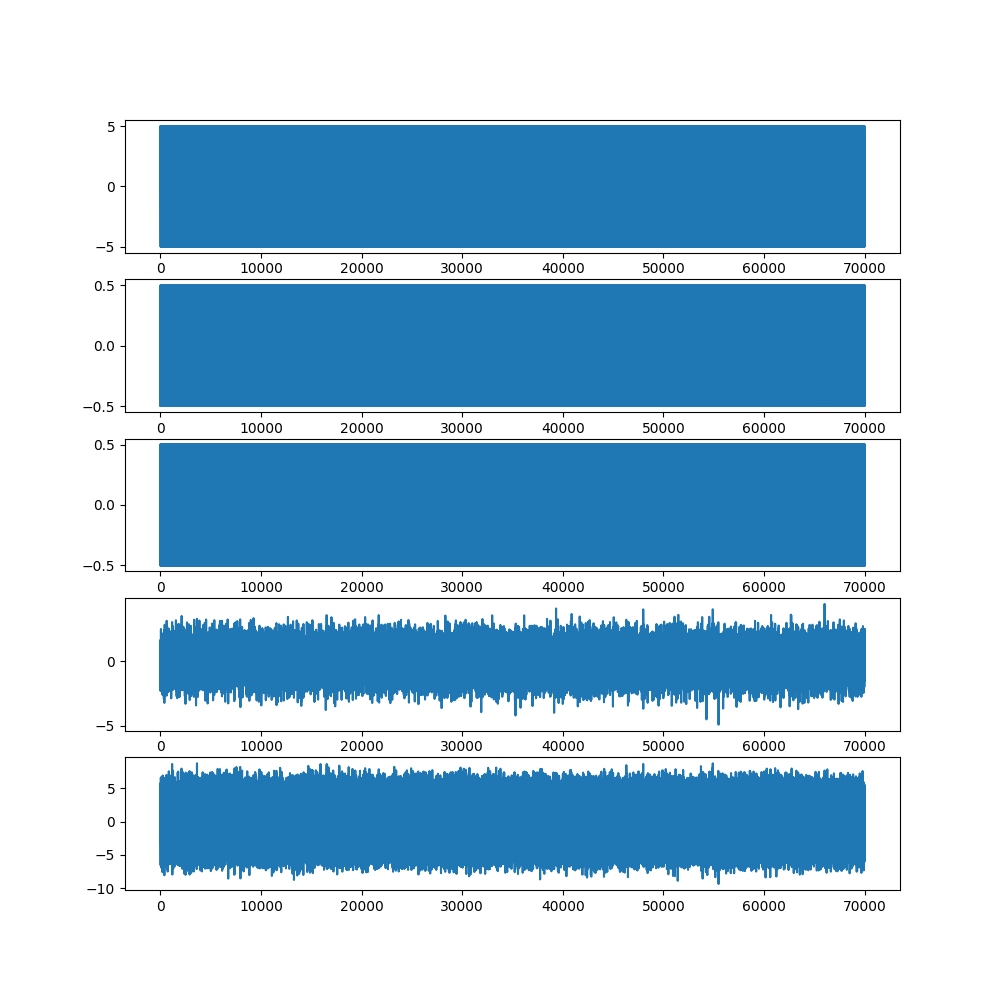

In [16]:
fig,ax=plt.subplots(5,1,figsize=(10,10))
ax[0].plot(n,5.0*np.sin(2.0*np.pi*(f1/Fs)*n))
ax[1].plot(n,0.5*np.sin(2.0*np.pi*(f2/Fs)*n))
ax[2].plot(n,0.5*np.sin(2.0*np.pi*(f3/Fs)*n))
ax[3].plot(n,sn)
ax[4].plot(n,signal_t)
plt.savefig(FIGS_DIR / 'ex10_time.pdf')

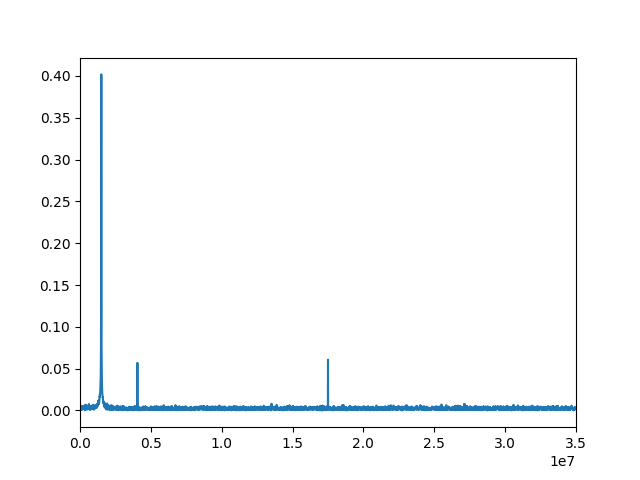

In [13]:
X=fp.fft(signal_t,2**13)
f=fp.fftfreq(2**13,d=1/Fs)
fig, ax = plt.subplots()
ax.plot(f[:2**12],(2/len(signal_t))*abs(X[:2**12]))
ax.set_xlim(0,Fs/2)
plt.savefig(FIGS_DIR / 'ex10_fft.pdf')

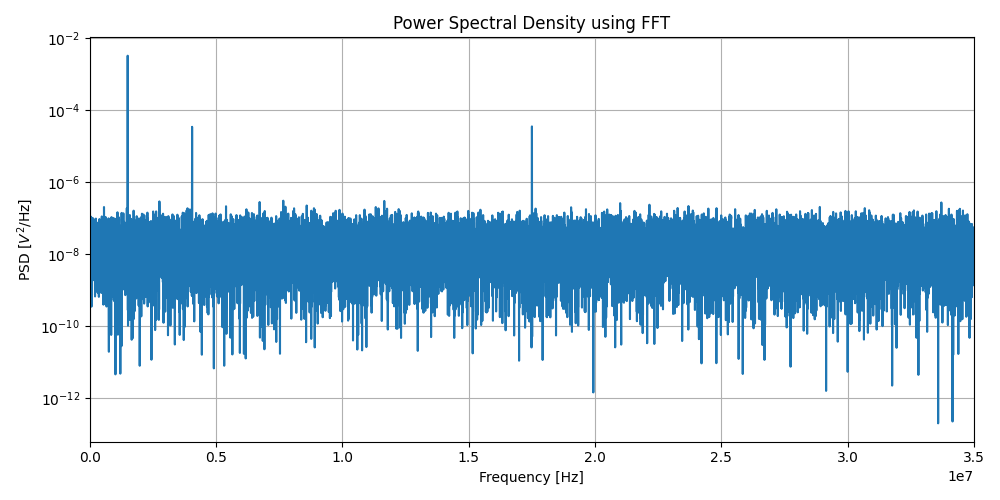

In [12]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

f, Pxx_spec = sg.periodogram(signal_t, Fs, 'flattop', scaling='density')
ax.semilogy(f, Pxx_spec)
ax.grid()
ax.set_title('Power Spectral Density using FFT')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'PSD [$V^2$/Hz]')
ax.set_xlim(0,Fs/2)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'ex10_psd.pdf')

## 11. Application example: Different time record analysis <a class="anchor" id="diff_time_record"></a>

## Introduction
Simulating (or measuring) signals and noise with an FFT is not trivial, because signals and noise do not behave in the same way when plotted as a power spectrum using an FFT.

This phenomenon can be explained intuitively: Let us do the following thought experiment: we use a sine signal of frequency 100 Hz and amplitude $\sqrt{2}$ and a white noise source with power spectral density $10^{-8}$ over the whole frequency range covered by the FFT. What happens if the simulation time is increased by a factor of 100, but the sampling time is left the same?

The answer directly follows from Parceval’s Theorem that states: the total signal power in the time domain and in the frequency domain is the same. If we just increase the simulation time, then the signal power does not change, so the amplitude of the signal stays the same. The noise power also does not change, but it is white noise, and occurs in all frequency bins of the FFT. We now have 100 times as
many frequency bins as before, so we have to expect that the signal power within one frequency bin is diminished by a factor of 100, or 20 dB. Figure 1 shows these two simulations next to each other. The 20 dB difference is well visible.

To see this in simulation is not trivial, for two reasons: first, the FFT itself also introduces a factor N, the length of the FFT, and second, as can be seen in the left plot of Fig. 1, the signal may obfuscate the noise because it is smeared out. The latter effect can be fought with windowing.

In [18]:
TSamp = 1e-4
fs= 1/TSamp              # Hz sample rate
TSim = [1e-1, 1e1]       # record time 
N = [int(fs*TSim[0]), int(fs*TSim[1])] #memory length
n = [np.arange(N[0]), np.arange(N[1])]
        
f0= 100          # Hz sine frequency
A = np.sqrt(2)   # V sine amplitude for P= 1 W into 1 ohm.
N0 = 1e-8        # PSD of noise in V^2/Hz
noise_power = N0 * fs / 2
#random noise generator
rng = np.random.default_rng()

# Signal 
x1= A*np.sin(2*np.pi*(f0/fs)*n[0]) 
x1+= rng.normal(scale=np.sqrt(noise_power), size=n[0].shape) # 1 W sinewave + noise

# Signal 
x2= A*np.sin(2*np.pi*(f0/fs)*n[1])
x2+= rng.normal(scale=np.sqrt(noise_power), size=n[1].shape) # 1 W sinewave + noise

print(N[0],N[1],len(x1),len(x2),TSim[0],TSim[1],N0,noise_power,A,fs)

1000 100000 1000 100000 0.1 10.0 1e-08 5e-05 1.4142135623730951 10000.0


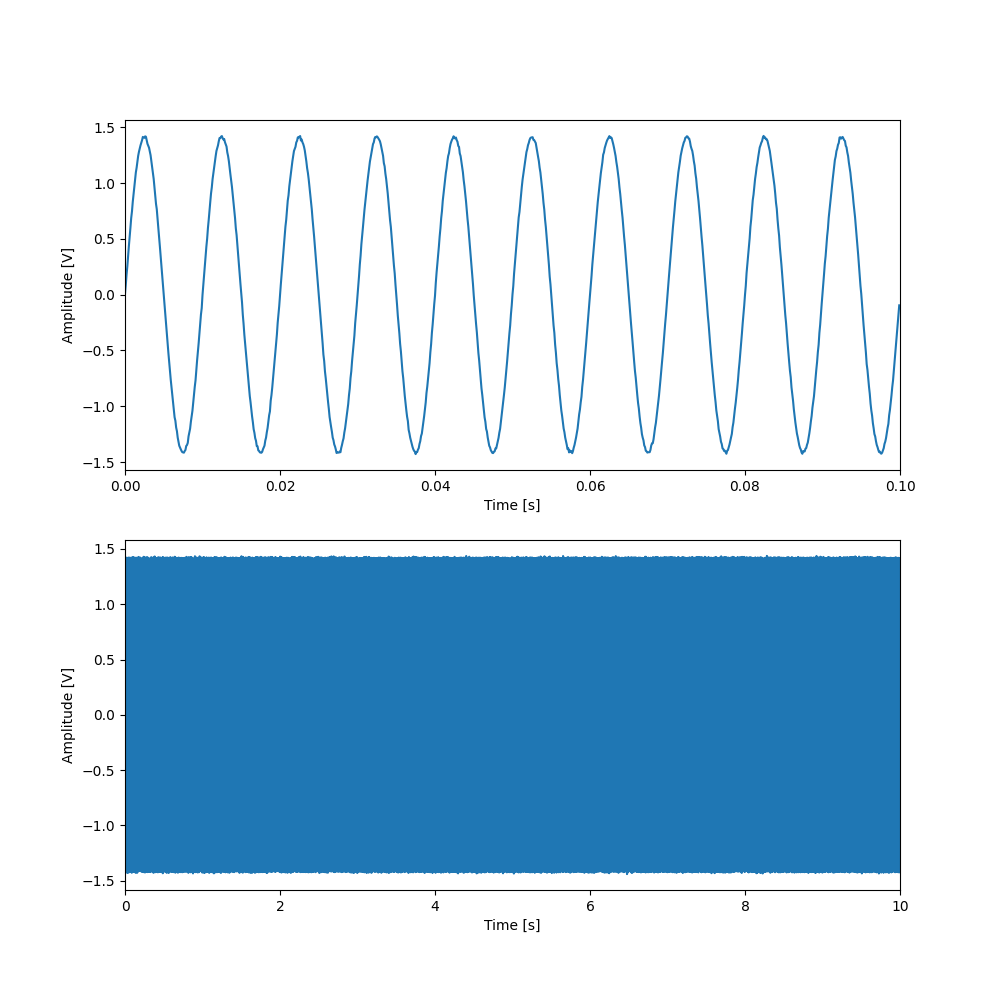

In [19]:
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(n[0]*TSamp,x1)
ax[0].set_xlim(0,n[0].size*TSamp)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude [V]')
ax[1].plot(n[1]*TSamp,x2)
ax[1].set_xlim(0,n[1].size*TSamp)
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Amplitude [V]')
plt.savefig(FIGS_DIR / 'ex11_time.pdf')

In [22]:
[f1,pxx1]= sg.welch(x1,fs,'boxcar',N[0],scaling='spectrum',detrend=False) 
PdB_Hz1 = 10*np.log10(pxx1)
#Recovering the PSD of noise
[f11,pxx11]= sg.welch(x1,fs,'boxcar',N[0],scaling='density',detrend=False) 
print(f'PSD of noise for N[0]: {np.mean(pxx11[int(pxx11.size/2):]):.2e}')

[f2,pxx2]= sg.welch(x2,fs,'boxcar',N[1],scaling='spectrum',detrend=False) 
PdB_Hz2 = 10*np.log10(pxx2) 
#Recovering the PSD of noise
[f22,pxx22]= sg.welch(x2,fs,'boxcar',N[1],scaling='density',detrend=False)
print(f'PSD of noise for N[1]: {np.mean(pxx22[int(pxx22.size/2):]):.2e}')

print(f'Mean value for Tsim={TSim[0]:.1e}: {np.mean(PdB_Hz1[50:]):.1f} dB')
print(f'Mean value for Tsim={TSim[1]:.1e}: {np.mean(PdB_Hz2[50:]):.1f} dB')
print(f'Difference: {np.mean(PdB_Hz2[50:])-np.mean(PdB_Hz1[50:]):.1f} dB')

PSD of noise for N[0]: 9.91e-09
PSD of noise for N[1]: 1.01e-08
Mean value for Tsim=1.0e-01: -72.6 dB
Mean value for Tsim=1.0e+01: -92.5 dB
Difference: -19.9 dB


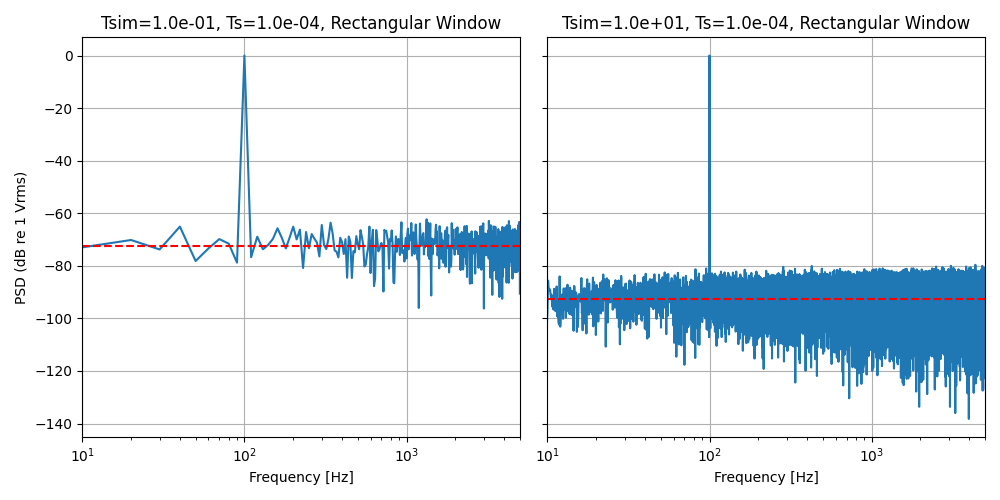

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)

ax[0].semilogx(f1, PdB_Hz1)
ax[0].axhline(np.mean(PdB_Hz1[50:]), ls="dashed", color="r")
ax[0].grid()
ax[0].set_title(f'Tsim={TSim[0]:.1e}, Ts={TSamp:.1e}, Rectangular Window')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel(r'PSD (dB re 1 Vrms)')
ax[0].set_xlim(10,fs/2)

ax[1].semilogx(f2, PdB_Hz2)
ax[1].axhline(np.mean(PdB_Hz2[50:]), ls="dashed", color="r")
ax[1].grid()
ax[1].set_title(f'Tsim={TSim[1]:.1e}, Ts={TSamp:.1e}, Rectangular Window')
ax[1].set_xlabel('Frequency [Hz]')
#ax[1].set_ylabel(r'PSD (dB re 1 Vrms)')
ax[1].set_xlim(10,fs/2)

plt.tight_layout()
plt.savefig(FIGS_DIR / 'ex11_psd.pdf')